# PDI - Rebalancing data for June 2022

## Setting

In [2]:
import pandas as pd
import numpy as np
import requests

In [3]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [4]:
from defillama import DefiLlama
llama = DefiLlama()

In [58]:
import plotly.express as px
import plotly.graph_objects as go

In [59]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Data retrieving and filtering

### Token inclusion criteria

1. **Project and token characteristics** 
    1. The project must have a listing on Defi Llama
    1. The project’s token should have been listed on CoinGecko with pricing data at least 1 year prior to the date of inclusion in the index. 
    1. The project should have a token that is native to Ethereum L1 or L2. This excludes wrapped variants, where the underlying tokens are locked on an alt-L1.
    1. The project should be a going concern, with a dedicated team actively building, supporting and maintaining the project. 
    1. No rebasing or deflationary tokens.
    1. The project must be widely considered to be building a useful protocol or product. Projects that have ponzi characteristics at the core of their offering will not be considered.
    1. Synthetic tokens which derive their value from external price feeds are not permissible. 
    1. The project’s token must not have the ability to pause token transfers.
    1. The project’s protocol or product must have significant usage.

1. **Liquidity Requirements**
    1. The token must be listed on a supported exchange.
    1. The token should have at least $5mm of onchain liquidity on a single pair.
    1. The token must have shown consistent DeFi liquidity on Ethereum.

1. **Security Requirements**
    1. The project must have been audited by smart contract security professionals with the audit report(s) publicly available. Alternatively, the protocol must have been operating long enough to create a consensus about its safety in the decentralised finance community.

### Tokens list

#### DefiLlama

In [5]:
protocols = llama.get_all_protocols()

In [6]:
top_defi_tokens = {} 
for pr in protocols[:500]:
    if 'Ethereum' in pr['chains'] and pr['address'] and pr['address']!='-' and pr['symbol'] != '-':
        symbol = pr['symbol'].upper()
        top_defi_tokens[symbol] = {
            'symbol': symbol, 
            'address': pr['address'].lower()
        }

In [7]:
top_defi_tokens['XSUSHI'] = {
    'symbol': 'XSUSHI',
    'address': "0x8798249c2e607446efb7ad49ec89dd1865ff4272",
}

#### CoinGecko

##### Tokens addresses

In [8]:
coins_list = pd.DataFrame(cg.get_coins_list(include_platform=True))

In [9]:
tokens = {} 
tokens_by_addr = {}
for index, coin in coins_list.iterrows():
    if len(coin['platforms']) >= 1 and 'ethereum' in list(coin['platforms'].keys()):
        symbol = coin['symbol'].upper()
        address = coin['platforms']['ethereum'].lower()
        token = {
            'symbol': symbol,
            'address': address 
        }
        tokens[symbol] = token
        tokens_by_addr[address] = token

In [10]:
tokens['USDC'], tokens['WETH']

({'symbol': 'USDC', 'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 {'symbol': 'WETH', 'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'})

In [11]:
# These token's addresses cant be found in the coingecko list of eth addresses
exclude_symbols = []
for symb, token in top_defi_tokens.items():
    if token['address'] not in tokens_by_addr.keys():
        print(token)
        exclude_symbols.append(token['symbol'])

{'symbol': 'MULTI', 'address': '0x9fb9a33956351cf4fa040f65a13b835a3c8764e3'}
{'symbol': 'IB', 'address': 'fantom:0x00a35fd824c717879bf370e70ac6868b95870dfb'}
{'symbol': 'COW', 'address': 'heco:0x80861a817106665bca173db6ac2ab628a738c737'}
{'symbol': 'TIME', 'address': 'avax:0xb54f16fb19478766a268f172c9480f8da1a7c9c3'}
{'symbol': 'ABR', 'address': 'celo:0x6e512bfc33be36f2666754e996ff103ad1680cc9'}
{'symbol': 'FLAG', 'address': '0x57dd84042ec9507963016596a34edad42f7e4cce '}
{'symbol': 'LYRA', 'address': 'optimism:0x50c5725949a6f0c72e6c4a641f24049a917db0cb'}
{'symbol': 'SGT', 'address': '0x84810bcf08744d5862b8181f12d17bfd57d3b078'}
{'symbol': 'HND', 'address': 'hundredfinance.jpg'}
{'symbol': 'FHM', 'address': '0xfa1fbb8ef55a4855e5688c0ee13ac3f202486286'}
{'symbol': 'SOLV', 'address': '0x256f2d67e52fe834726d2ddcd8413654f5eb8b53'}
{'symbol': 'RSR', 'address': '0x8762db106b2c2a0bccb3a80d1ed41273552616e8'}
{'symbol': 'USDS', 'address': 'arbitrum:0xd74f5255d557944cf7dd0e45ff521520002d5748'}
{'

In [12]:
for symb in exclude_symbols:
    del top_defi_tokens[symb]

In [13]:
# KEEP has this address in defillama, but etherscan says this address belongs to tBTC now
for token in top_defi_tokens.values():
    if token['address'] == "0x8daebade922df735c38c80c7ebd708af50815faa":
        print(token)
del top_defi_tokens['KEEP']

{'symbol': 'KEEP', 'address': '0x8daebade922df735c38c80c7ebd708af50815faa'}


##### Market data

In [14]:
cg_tokens_data = pd.DataFrame(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc'))
for i in range(2, 20):
    cg_tokens_data = cg_tokens_data.append(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', page=i))

In [15]:
tokens_market_data = cg_tokens_data.set_index(cg_tokens_data['symbol'].str.upper())

In [16]:
tokens_market_data.head()

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
BTC,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,31147.000,594329114724,1,6.556439e+11,7.082571e+10,32660.000,...,2.100000e+07,21000000.0,69045.00,-54.78612,2021-11-10T14:24:11.849Z,67.810000,45937.87225,2013-07-06T00:00:00.000Z,None,2022-05-10T15:11:15.451Z
ETH,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2361.280,286421901231,2,NaN,4.327144e+10,2453.600,...,NaN,NaN,4878.26,-51.39155,2021-11-10T14:24:19.604Z,0.432979,547558.83620,2015-10-20T00:00:00.000Z,"{'times': 100.10421933153451, 'currency': 'btc...",2022-05-10T15:10:51.416Z
USDT,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.001,83592237312,3,NaN,1.327052e+11,1.010,...,8.316719e+10,NaN,1.32,-24.05882,2018-07-24T00:00:00.000Z,0.572521,75.49996,2015-03-02T00:00:00.000Z,None,2022-05-10T15:12:13.142Z
BNB,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,317.660,53722407652,4,5.372241e+10,4.665375e+09,331.840,...,1.681370e+08,168137035.9,686.31,-53.45845,2021-05-10T07:24:17.097Z,0.039818,802100.39956,2017-10-19T00:00:00.000Z,None,2022-05-10T15:12:48.094Z
USDC,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,1.002,48803659120,5,NaN,1.180834e+10,1.008,...,4.854559e+10,NaN,1.17,-14.21690,2019-05-08T00:40:28.300Z,0.891848,12.79767,2021-05-19T13:14:05.611Z,None,2022-05-10T15:12:25.326Z


### Liquidity check

In [17]:
dex_subgraph_urls = {
    'univ2': "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2",
    'sushi': "https://api.thegraph.com/subgraphs/name/zippoxer/sushiswap-subgraph-fork",
} 

In [18]:
base_tokens = [tokens['USDC'], tokens['WETH']]
base_tokens

[{'symbol': 'USDC', 'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 {'symbol': 'WETH', 'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'}]

In [19]:
query = """
    query pairs ($token0_ids: [ID!]!, $token1_ids: [ID!]!) {
        pairs (first:1000, where: {token0_in: $token0_ids, token1_in: $token1_ids}){
            id
            token0 {
              id
            }
            token1 {
              id
            }
            reserveUSD
        }
    }
    """

In [20]:
base_tokens_ids = [token['address'] for token in base_tokens]
tokens_ids = [token['address'] for symb, token in top_defi_tokens.items()]

In [21]:
rows = {token['symbol']: {} for token in top_defi_tokens.values()}
for dex_name, url in dex_subgraph_urls.items():
    request = requests.post(url, json={'query': query, 'variables': {'token0_ids': base_tokens_ids, 'token1_ids': tokens_ids}})
    pairs1 = request.json()['data']['pairs']

    request = requests.post(url, json={'query': query, 'variables': {'token0_ids': tokens_ids, 'token1_ids': base_tokens_ids}})
    pairs2 = request.json()['data']['pairs']
    
    pairs = pairs1 + pairs2
    
    print(f"{dex_name}: {len(pairs)} pairs")
    
    for pair in pairs:
        if pair['token0']['id'] in base_tokens_ids:
            base_token = tokens_by_addr[pair['token0']['id']]
            token = tokens_by_addr[pair['token1']['id']]
        else:
            base_token = tokens_by_addr[pair['token1']['id']]
            token = tokens_by_addr[pair['token0']['id']]
        
        colname = f"{dex_name}_{base_token['symbol']}" 
        
        rows[token['symbol'].upper()][colname] = float(pair['reserveUSD'])

univ2: 161 pairs
sushi: 97 pairs


In [22]:
liquidities = pd.DataFrame.from_dict(rows, orient='index')
liq_check = (liquidities > 5e6).any(axis=1).sort_values(ascending=False)
liq_check_passed = liq_check[liq_check]

In [23]:
lq_passed = tokens_market_data[
    tokens_market_data.index.isin(liq_check_passed.index)
]

In [24]:
lq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
WBTC,wrapped-bitcoin,wbtc,Wrapped Bitcoin,https://assets.coingecko.com/coins/images/7598...,31156.000000,8919680793,17,8.919681e+09,8.849172e+08,32655.000000,...,2.842049e+05,2.842049e+05,70643.000000,-55.57309,2021-11-10T14:40:19.650Z,3139.170000,899.77530,2019-04-02T00:00:00.000Z,None,2022-05-10T15:12:40.051Z
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,6.270000,2897891360,34,6.348209e+09,4.018164e+08,6.890000,...,1.000000e+09,1.000000e+09,44.920000,-85.86667,2021-05-03T05:25:04.822Z,1.030000,516.24877,2020-09-17T01:20:38.214Z,None,2022-05-10T15:11:48.721Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,109.670000,1523395005,55,1.777424e+09,4.944676e+08,117.710000,...,1.600000e+07,1.600000e+07,661.690000,-83.20358,2021-05-18T21:19:59.514Z,26.020000,327.08236,2020-11-05T09:20:11.928Z,None,2022-05-10T15:11:24.784Z
FXS,frax-share,fxs,Frax Share,https://assets.coingecko.com/coins/images/1342...,18.850000,1139944239,74,1.870544e+09,7.698783e+07,21.300000,...,9.887491e+07,9.887491e+07,42.800000,-55.81446,2022-01-12T15:22:27.465Z,1.500000,1158.10350,2021-06-25T16:50:51.447Z,None,2022-05-10T15:11:45.273Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,1200.260000,1090636937,76,1.216805e+09,1.751395e+08,1250.290000,...,9.776310e+05,1.005577e+06,6292.310000,-80.78299,2021-05-03T21:54:29.333Z,168.360000,618.22997,2020-03-16T20:52:36.527Z,None,2022-05-10T15:11:44.726Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,2.150000,747724503,100,2.181562e+09,6.049160e+07,2.440000,...,1.000000e+09,1.000000e+09,7.300000,-70.12734,2021-08-20T08:35:20.158Z,0.505506,331.56021,2021-03-27T09:10:29.155Z,None,2022-05-10T15:12:39.361Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,89.070000,618128439,110,9.016608e+08,1.421411e+08,94.730000,...,1.000000e+07,1.000000e+07,910.540000,-90.09755,2021-05-12T02:29:08.794Z,61.320000,47.03725,2020-06-18T12:54:32.788Z,None,2022-05-10T15:11:15.456Z
SYN,synapse-2,syn,Synapse,https://assets.coingecko.com/coins/images/1802...,2.820000,520427087,118,7.064450e+08,3.295197e+07,3.150000,...,NaN,2.500000e+08,4.920000,-42.35177,2021-10-24T00:24:41.805Z,0.389600,627.32311,2021-09-21T21:19:58.123Z,None,2022-05-10T15:12:43.037Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,14117.220000,508333659,120,5.233456e+08,2.031377e+08,14935.630000,...,3.666600e+04,3.666600e+04,90787.000000,-84.27821,2021-05-12T00:29:37.713Z,31.650000,45004.30377,2020-07-18T12:26:27.150Z,None,2022-05-10T15:11:44.714Z


### Non quantative checks

In [25]:
exclude_list = [
    {
        'symbol': 'WBTC',
        'reason': 'Criteria 1.C'
    },
    {
        'symbol': 'XSUSHI',
        'reason': 'duplicates SUSHI'
    },
    {
        'symbol': 'ERN',
        'resason': 'not DeFi'
    },
    {
        'symbol': 'NFTX',
        'resason': 'not DeFi'
    },
    {
        'symbol': 'FXS',
        'reason': 'Criteria 1.G'
    }
]
exclude_symbols = [token['symbol'] for token in exclude_list]

In [26]:
nq_passed = lq_passed[
    ~lq_passed.index.isin(exclude_symbols)
]

In [27]:
nq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,6.270000,2897891360,34,6.348209e+09,4.018164e+08,6.890000,...,1.000000e+09,1.000000e+09,44.920000,-85.86667,2021-05-03T05:25:04.822Z,1.030000,516.24877,2020-09-17T01:20:38.214Z,None,2022-05-10T15:11:48.721Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,109.670000,1523395005,55,1.777424e+09,4.944676e+08,117.710000,...,1.600000e+07,1.600000e+07,661.690000,-83.20358,2021-05-18T21:19:59.514Z,26.020000,327.08236,2020-11-05T09:20:11.928Z,None,2022-05-10T15:11:24.784Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,1200.260000,1090636937,76,1.216805e+09,1.751395e+08,1250.290000,...,9.776310e+05,1.005577e+06,6292.310000,-80.78299,2021-05-03T21:54:29.333Z,168.360000,618.22997,2020-03-16T20:52:36.527Z,None,2022-05-10T15:11:44.726Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,2.150000,747724503,100,2.181562e+09,6.049160e+07,2.440000,...,1.000000e+09,1.000000e+09,7.300000,-70.12734,2021-08-20T08:35:20.158Z,0.505506,331.56021,2021-03-27T09:10:29.155Z,None,2022-05-10T15:12:39.361Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,89.070000,618128439,110,9.016608e+08,1.421411e+08,94.730000,...,1.000000e+07,1.000000e+07,910.540000,-90.09755,2021-05-12T02:29:08.794Z,61.320000,47.03725,2020-06-18T12:54:32.788Z,None,2022-05-10T15:11:15.456Z
SYN,synapse-2,syn,Synapse,https://assets.coingecko.com/coins/images/1802...,2.820000,520427087,118,7.064450e+08,3.295197e+07,3.150000,...,NaN,2.500000e+08,4.920000,-42.35177,2021-10-24T00:24:41.805Z,0.389600,627.32311,2021-09-21T21:19:58.123Z,None,2022-05-10T15:12:43.037Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,14117.220000,508333659,120,5.233456e+08,2.031377e+08,14935.630000,...,3.666600e+04,3.666600e+04,90787.000000,-84.27821,2021-05-12T00:29:37.713Z,31.650000,45004.30377,2020-07-18T12:26:27.150Z,None,2022-05-10T15:11:44.714Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.870000,363472609,157,4.713341e+08,4.241692e+08,2.000000,...,2.420692e+08,2.500000e+08,23.380000,-91.93488,2021-03-13T23:44:36.774Z,0.475381,296.59520,2020-11-04T14:53:53.560Z,None,2022-05-10T15:10:51.544Z
SPELL,spell-token,spell,Spell Token,https://assets.coingecko.com/coins/images/1586...,0.002463,221655918,210,5.198815e+08,5.739195e+07,0.002758,...,1.960087e+11,2.100000e+11,0.035064,-92.93444,2021-11-02T08:44:42.429Z,0.000298,731.00864,2021-08-05T13:00:27.077Z,None,2022-05-10T15:11:45.505Z


### Retrieve historical data & livetime check

In [28]:
exclude_list = []

prices_data = pd.DataFrame()
marketcaps = pd.DataFrame() 
for index, data in nq_passed[['id', 'symbol']].iterrows():
    id_ = data['id']
    symbol = data['symbol'].upper()
    data = cg.get_coin_market_chart_by_id(id_, vs_currency='USD', days='max')
  
    df_prices = pd.DataFrame(data['prices'], columns=['date', symbol])
    df_prices = df_prices[df_prices[symbol] > 0]
    df_prices['date'] = pd.to_datetime(df_prices['date'], unit='ms').dt.date
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date', drop=True)
    df_prices = df_prices.loc[~df_prices.index.duplicated(keep='first')]
    
    if len(df_prices) < 365:
        print(f'Excluding {symbol}, prices data available only for {len(df_prices)} < 365 days')
        exclude_list.append(symbol)
        continue
    prices_data = pd.concat([prices_data, df_prices], axis=1)
    
    df_mcaps = pd.DataFrame(data['market_caps'], columns=['date', symbol])
    df_mcaps = df_mcaps[df_mcaps[symbol] > 0]
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'], unit='ms').dt.date
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'])
    df_mcaps = df_mcaps.set_index('date', drop=True)
    df_mcaps = df_mcaps.loc[~df_mcaps.index.duplicated(keep='first')]
    
    if len(df_mcaps) < 365:
        print(f'Note: {symbol}, marketcap data available only for {len(df_mcaps)} < 365 days')
        ## continue
    df_mcaps = df_mcaps.reindex(df_prices.index)
    marketcaps = pd.concat([marketcaps, df_mcaps], axis=1)
    
    

Excluding SYN, prices data available only for 254 < 365 days
Excluding SPELL, prices data available only for 348 < 365 days
Excluding TOKE, prices data available only for 277 < 365 days
Excluding FLX, prices data available only for 149 < 365 days


In [29]:
lt_passed = nq_passed[
    ~nq_passed.index.isin(exclude_list)
]

In [30]:
lt_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,6.27,2897891360,34,6.348209e+09,401816374.0,6.89,...,1.000000e+09,1.000000e+09,44.92,-85.86667,2021-05-03T05:25:04.822Z,1.030000,516.24877,2020-09-17T01:20:38.214Z,None,2022-05-10T15:11:48.721Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,109.67,1523395005,55,1.777424e+09,494467552.0,117.71,...,1.600000e+07,1.600000e+07,661.69,-83.20358,2021-05-18T21:19:59.514Z,26.020000,327.08236,2020-11-05T09:20:11.928Z,None,2022-05-10T15:11:24.784Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,1200.26,1090636937,76,1.216805e+09,175139522.0,1250.29,...,9.776310e+05,1.005577e+06,6292.31,-80.78299,2021-05-03T21:54:29.333Z,168.360000,618.22997,2020-03-16T20:52:36.527Z,None,2022-05-10T15:11:44.726Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,2.15,747724503,100,2.181562e+09,60491604.0,2.44,...,1.000000e+09,1.000000e+09,7.30,-70.12734,2021-08-20T08:35:20.158Z,0.505506,331.56021,2021-03-27T09:10:29.155Z,None,2022-05-10T15:12:39.361Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,89.07,618128439,110,9.016608e+08,142141076.0,94.73,...,1.000000e+07,1.000000e+07,910.54,-90.09755,2021-05-12T02:29:08.794Z,61.320000,47.03725,2020-06-18T12:54:32.788Z,None,2022-05-10T15:11:15.456Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,14117.22,508333659,120,5.233456e+08,203137658.0,14935.63,...,3.666600e+04,3.666600e+04,90787.00,-84.27821,2021-05-12T00:29:37.713Z,31.650000,45004.30377,2020-07-18T12:26:27.150Z,None,2022-05-10T15:11:44.714Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.87,363472609,157,4.713341e+08,424169236.0,2.00,...,2.420692e+08,2.500000e+08,23.38,-91.93488,2021-03-13T23:44:36.774Z,0.475381,296.59520,2020-11-04T14:53:53.560Z,None,2022-05-10T15:10:51.544Z
RGT,rari-governance-token,rgt,Rari Governance Token,https://assets.coingecko.com/coins/images/1290...,9.32,105759615,330,1.173128e+08,410536.0,9.66,...,1.248505e+07,1.248505e+07,64.62,-85.45831,2021-11-05T02:35:18.635Z,0.213385,4303.43080,2020-11-05T19:59:44.138Z,None,2022-05-10T15:11:24.134Z
ALCX,alchemix,alcx,Alchemix,https://assets.coingecko.com/coins/images/1411...,47.08,60469961,464,1.126118e+08,6130993.0,49.68,...,1.988267e+06,2.393060e+06,2066.20,-97.72250,2021-03-20T19:33:19.740Z,44.720000,5.22634,2022-05-10T00:29:50.560Z,None,2022-05-10T15:11:30.707Z


### Marketcap ranking & top10 filtering

In [31]:
chosen_tokens = lt_passed.sort_values("market_cap", ascending=False).iloc[:10]

In [32]:
chosen_tokens

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,6.27,2897891360,34,6.348209e+09,401816374.0,6.89,...,1.000000e+09,1.000000e+09,44.92,-85.86667,2021-05-03T05:25:04.822Z,1.030000,516.24877,2020-09-17T01:20:38.214Z,None,2022-05-10T15:11:48.721Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,109.67,1523395005,55,1.777424e+09,494467552.0,117.71,...,1.600000e+07,1.600000e+07,661.69,-83.20358,2021-05-18T21:19:59.514Z,26.020000,327.08236,2020-11-05T09:20:11.928Z,None,2022-05-10T15:11:24.784Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,1200.26,1090636937,76,1.216805e+09,175139522.0,1250.29,...,9.776310e+05,1.005577e+06,6292.31,-80.78299,2021-05-03T21:54:29.333Z,168.360000,618.22997,2020-03-16T20:52:36.527Z,None,2022-05-10T15:11:44.726Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,2.15,747724503,100,2.181562e+09,60491604.0,2.44,...,1.000000e+09,1.000000e+09,7.30,-70.12734,2021-08-20T08:35:20.158Z,0.505506,331.56021,2021-03-27T09:10:29.155Z,None,2022-05-10T15:12:39.361Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,89.07,618128439,110,9.016608e+08,142141076.0,94.73,...,1.000000e+07,1.000000e+07,910.54,-90.09755,2021-05-12T02:29:08.794Z,61.320000,47.03725,2020-06-18T12:54:32.788Z,None,2022-05-10T15:11:15.456Z
YFI,yearn-finance,yfi,yearn.finance,https://assets.coingecko.com/coins/images/1184...,14117.22,508333659,120,5.233456e+08,203137658.0,14935.63,...,3.666600e+04,3.666600e+04,90787.00,-84.27821,2021-05-12T00:29:37.713Z,31.650000,45004.30377,2020-07-18T12:26:27.150Z,None,2022-05-10T15:11:44.714Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.87,363472609,157,4.713341e+08,424169236.0,2.00,...,2.420692e+08,2.500000e+08,23.38,-91.93488,2021-03-13T23:44:36.774Z,0.475381,296.59520,2020-11-04T14:53:53.560Z,None,2022-05-10T15:10:51.544Z
RGT,rari-governance-token,rgt,Rari Governance Token,https://assets.coingecko.com/coins/images/1290...,9.32,105759615,330,1.173128e+08,410536.0,9.66,...,1.248505e+07,1.248505e+07,64.62,-85.45831,2021-11-05T02:35:18.635Z,0.213385,4303.43080,2020-11-05T19:59:44.138Z,None,2022-05-10T15:11:24.134Z
ALCX,alchemix,alcx,Alchemix,https://assets.coingecko.com/coins/images/1411...,47.08,60469961,464,1.126118e+08,6130993.0,49.68,...,1.988267e+06,2.393060e+06,2066.20,-97.72250,2021-03-20T19:33:19.740Z,44.720000,5.22634,2022-05-10T00:29:50.560Z,None,2022-05-10T15:11:30.707Z


In [33]:
chosen_tokens_symbols = list(chosen_tokens.index)
prices_data = prices_data[chosen_tokens_symbols]
marketcaps = marketcaps[chosen_tokens_symbols]

In [34]:
without_nan_index = (marketcaps.isnull().sum(axis=1) == 0) & (prices_data.isnull().sum(axis=1) == 0)
marketcaps = marketcaps[without_nan_index]
prices_data = prices_data[without_nan_index]

In [35]:
prices_data

,UNI,AAVE,MKR,LDO,COMP,YFI,SUSHI,RGT,ALCX,BOND
date,,,,,,,,,,
2021-03-02,25.592699,386.507922,2178.689085,0.849448,494.358379,34900.371111,18.798040,9.244510,1050.297397,56.050115
2021-03-03,25.673868,392.581993,2174.258188,0.879645,501.438114,33400.696195,17.925825,9.187071,991.795750,52.260027
2021-03-04,25.486634,397.858343,2206.022345,0.836782,494.206140,33881.025287,17.517664,15.560666,1376.135328,57.280345
2021-03-05,28.368215,376.610205,2204.725033,0.687990,472.457882,32560.148658,17.408828,13.633827,1139.907512,55.329831
2021-03-06,28.308459,369.647205,2072.617638,0.783612,479.153858,32137.453888,16.690631,15.572123,1167.196998,58.316153
...,...,...,...,...,...,...,...,...,...,...
2022-05-06,7.333328,141.727487,1377.420980,2.802636,104.554781,16912.527887,2.277430,9.905660,60.443008,5.667250
2022-05-07,7.629119,138.661216,1336.128099,2.777171,103.406585,16775.780224,2.253239,9.724195,58.866954,5.320555
2022-05-08,7.192052,132.506200,1268.358751,2.719063,98.818657,16469.379195,2.145951,9.661774,54.410386,5.322503


In [54]:
marketcaps

,UNI,AAVE,MKR,LDO,COMP,YFI,SUSHI,RGT,ALCX,BOND
date,,,,,,,,,,
2021-03-02,7.871645e+09,4.751222e+09,1.959551e+09,1.181185e+07,2.142571e+09,1.237769e+09,2.362758e+09,7.905497e+07,3.338203e+07,7.552599e+07
2021-03-03,7.938771e+09,4.878411e+09,1.953753e+09,1.224257e+07,2.175709e+09,1.188119e+09,2.273568e+09,7.802549e+07,3.126962e+07,7.110369e+07
2021-03-04,7.933740e+09,4.948727e+09,1.995893e+09,1.185368e+07,2.154215e+09,1.210977e+09,2.240011e+09,1.338503e+08,4.418676e+07,7.802084e+07
2021-03-05,8.803390e+09,4.684718e+09,1.982026e+09,9.733795e+06,2.054969e+09,1.156134e+09,2.211941e+09,1.164950e+08,3.647704e+07,7.517484e+07
2021-03-06,8.703822e+09,4.580840e+09,1.868843e+09,1.101787e+07,2.077348e+09,1.153659e+09,2.123790e+09,1.331889e+08,3.716741e+07,7.902313e+07
...,...,...,...,...,...,...,...,...,...,...
2022-05-06,3.333194e+09,1.941047e+09,1.238661e+09,9.285244e+08,7.041425e+08,6.029173e+08,4.388844e+08,1.115758e+08,7.726369e+07,3.764928e+07
2022-05-07,3.483254e+09,1.904147e+09,1.207020e+09,9.261591e+08,6.976778e+08,5.986206e+08,4.339285e+08,1.057752e+08,7.563675e+07,3.516116e+07
2022-05-08,3.289505e+09,1.822760e+09,1.142344e+09,9.144418e+08,6.664658e+08,5.877526e+08,4.147377e+08,1.090277e+08,7.081123e+07,3.535247e+07


## Weighting 

**Weighting requirements**
* The maximum weight any one token can have is 30%.
* All excess weight is proportionally redistributed to all uncapped tokens. After this has been completed, if another token now exceeds the 30% threshold the excess will be redistributed to the remaining uncapped tokens. This process will occur iteratively until there are no tokens that exceed the maximum weight.
* Any asset with a weight below 0.5% will be removed from the index.


### Iterative proportional adjusting

In [37]:
def adjust_weights(w, b):
    assert abs(w.sum() - 1) < 0.01, w.sum()
    assert b * w.shape[0] >=1
    wa = w.copy()
    
    while (wa > b).any():
        c = (wa[wa>b]-b).sum()
        wa[wa > b] = b
        w_less = wa[wa < b]
        wa[wa < b] += c * (w_less / w_less.sum())
    
    return wa

### Weight mcaps

In [61]:
weights = marketcaps.div(marketcaps.sum(axis=1), axis=0)
weights = weights.sort_values(weights.last_valid_index(), axis=1, ascending=False)

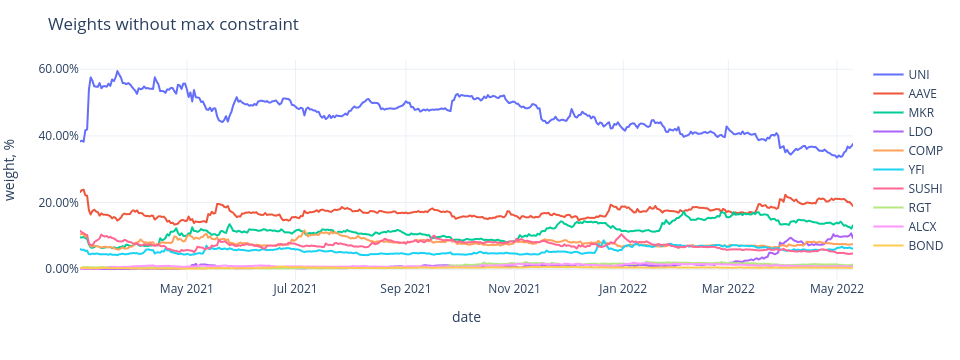

In [62]:
fig = px.line(weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    ## showlegend=False,
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights without max constraint'
)

In [63]:
weights

,UNI,AAVE,MKR,LDO,COMP,YFI,SUSHI,RGT,ALCX,BOND
date,,,,,,,,,,
2021-03-02,0.383510,0.231481,0.095470,0.000575,0.104387,0.060305,0.115114,0.003852,0.001626,0.003680
2021-03-03,0.385359,0.236805,0.094838,0.000594,0.105612,0.057673,0.110362,0.003787,0.001518,0.003451
2021-03-04,0.382322,0.238476,0.096181,0.000571,0.103810,0.058356,0.107945,0.006450,0.002129,0.003760
2021-03-05,0.416609,0.221698,0.093797,0.000461,0.097249,0.054713,0.104677,0.005513,0.001726,0.003558
2021-03-06,0.419084,0.220565,0.089984,0.000531,0.100023,0.055548,0.102259,0.006413,0.001790,0.003805
...,...,...,...,...,...,...,...,...,...,...
2022-05-06,0.354073,0.206190,0.131578,0.098634,0.074798,0.064046,0.046621,0.011852,0.008207,0.003999
2022-05-07,0.367922,0.201127,0.127492,0.097826,0.073693,0.063230,0.045834,0.011173,0.007989,0.003714
2022-05-08,0.363353,0.201339,0.126181,0.101008,0.073617,0.064922,0.045811,0.012043,0.007822,0.003905


### Adjust weights

In [64]:
adjusted_weights = weights.apply(adjust_weights, args=[0.3], axis=1)
adjusted_weights = adjusted_weights.loc[:, adjusted_weights.iloc[-1] > 0.005]

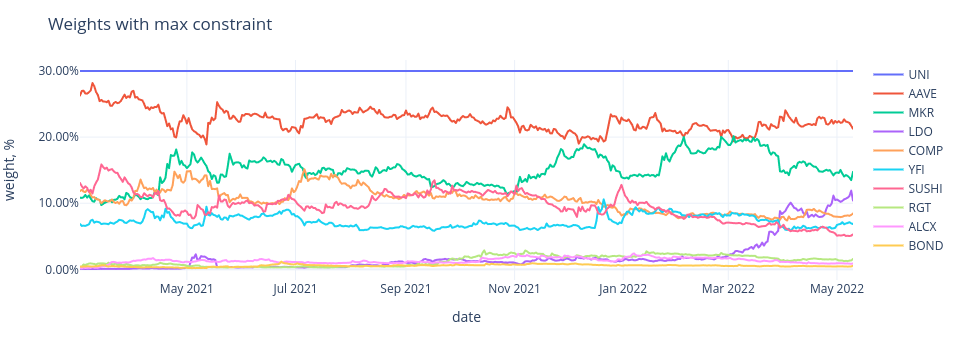

In [65]:
fig = px.line(adjusted_weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights with max constraint'
)

In [66]:
adjusted_weights

,UNI,AAVE,MKR,LDO,COMP,YFI,SUSHI,RGT,ALCX,BOND
date,,,,,,,,,,
2021-03-02,0.3,0.262838,0.108402,0.000653,0.118527,0.068473,0.130708,0.004373,0.001847,0.004178
2021-03-03,0.3,0.269691,0.108009,0.000677,0.120279,0.065682,0.125689,0.004313,0.001729,0.003931
2021-03-04,0.3,0.270259,0.108999,0.000647,0.117646,0.066134,0.122331,0.007310,0.002413,0.004261
2021-03-05,0.3,0.266012,0.112545,0.000553,0.116687,0.065649,0.125600,0.006615,0.002071,0.004269
2021-03-06,0.3,0.265779,0.108430,0.000639,0.120527,0.066935,0.123222,0.007728,0.002156,0.004585
...,...,...,...,...,...,...,...,...,...,...
2022-05-06,0.3,0.223451,0.142593,0.106891,0.081060,0.069407,0.050524,0.012844,0.008895,0.004334
2022-05-07,0.3,0.222740,0.141192,0.108339,0.081612,0.070024,0.050759,0.012373,0.008848,0.004113
2022-05-08,0.3,0.221374,0.138738,0.111059,0.080942,0.071383,0.050370,0.013241,0.008600,0.004294


In [67]:
adjusted_weights.iloc[-1]

UNI      0.300000
AAVE     0.212592
MKR      0.147526
LDO      0.104024
COMP     0.084374
YFI      0.068502
SUSHI    0.052917
RGT      0.015612
ALCX     0.008879
BOND     0.005576
Name: 2022-05-10 00:00:00, dtype: float64

In [82]:
pdi = pd.DataFrame()
pdi.index = chosen_tokens.index
pdi['name'] = chosen_tokens['name']
pdi['market_cap'] = marketcaps.iloc[-1].astype(int)
pdi['price'] = prices_data.iloc[-1]
pdi['weight'] = adjusted_weights.iloc[-1]
pdi['address'] = [top_defi_tokens[symb]['address'] for symb in pdi.index]

In [83]:
pdi

,name,market_cap,price,weight,address
symbol,,,,,
UNI,Uniswap,2779604665,6.028475,0.300000,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984
AAVE,Aave,1401183065,101.222514,0.212592,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9
MKR,Maker,972337032,1068.810527,0.147526,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2
LDO,Lido DAO,685615878,1.995360,0.104024,0x5a98fcbea516cf06857215779fd812ca3bef1b32
COMP,Compound,556103467,80.243161,0.084374,0xc00e94cb662c3520282e6f5717214004a7f26888
YFI,yearn.finance,451492594,12658.100281,0.068502,0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e
SUSHI,Sushi,348771622,1.779894,0.052917,0x6b3595068778dd592e39a122f4f5a5cf09c90fe2
RGT,Rari Governance Token,102895859,9.040115,0.015612,0xd291e7a03283640fdc51b121ac401383a46cc623
ALCX,Alchemix,58521180,45.515191,0.008879,0xdbdb4d16eda451d0503b854cf79d55697f90c8df
